In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
import os

# Quantum Circuits for partial differential equations via Schr\"odingerisation
# arxiv: http://arxiv.org/abs/2403.10032v2
# Copyright 2024 Shanghai Jiao Tong University. All Rights Reserved.

# Circuits

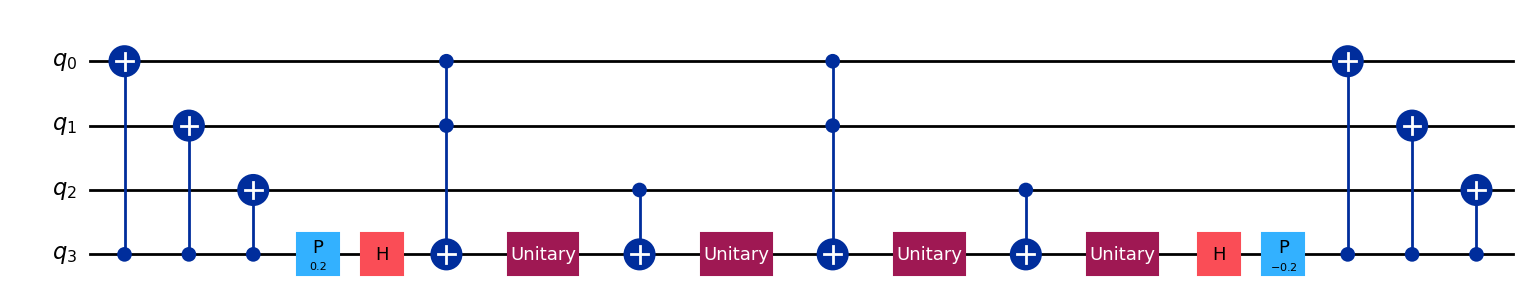

In [2]:
def Wj(j, theta, lam, name='Wj', xgate=False):
    # Wj
    
    # for the advection equation, set xgate=True to apply extra X gates
    # return U_1^1, U_2^1

    if not xgate:
        name = f' $W_{j}$ '
    qc=QuantumCircuit(j, name=name)

    if j > 1:
        qc.cx(j-1, range(j-1))
    if lam != 0:
        qc.p(lam, j-1)
    qc.h(j-1)
    if xgate:
        qc.x(range(j-1))

    # the multicontrolled rz gate 
    # it will be decomposed in qiskit
    if j > 1:
        qc.mcrz(theta, range(j-1), j-1)
    else:
        qc.rz(theta, j-1)
    
    if xgate:
        qc.x(range(j-1))
    qc.h(j-1)
    if lam != 0:
        qc.p(-lam, j-1)
    if j > 1:
        qc.cx(j-1, range(j-1))

    return qc

# example
test = Wj(4, 0.1, 0.2)
test.draw('mpl')

## Heat equation

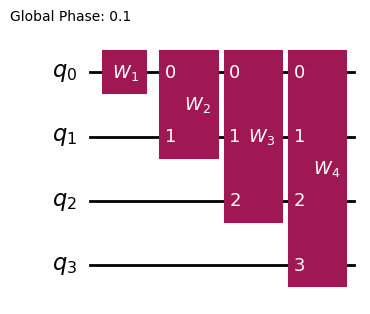

In [3]:
def V0(theta, n):
    # H1_circ for heat equation
    qc = QuantumCircuit(n, global_phase=theta, name='$V_0$')

    # apply wj
    for j in range(1, n+1):
        qc.append(Wj(j, theta, 0), range(j))
    return qc

# example 
test = V0(0.1, 4)
test.draw('mpl')

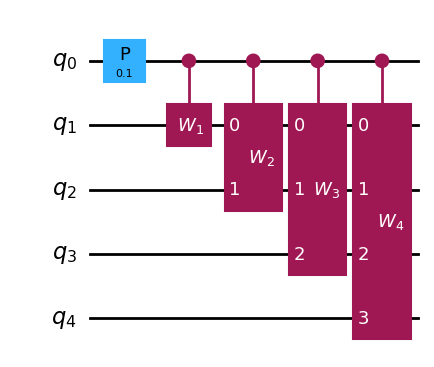

In [4]:
def cV0(theta, n):
    # cH1_circ for heat equation
    qc = QuantumCircuit(n+1, name='$cV_0$')
    qc.p(theta, 0)

    # apply controlled wj
    for j in range(1, n+1):
        cWj = Wj(j, theta, 0).to_gate().control()
        qc.append(cWj, range(j+1))
    return qc

# example
test = cV0(0.1, 4)
test.draw('mpl')

## Advection equation

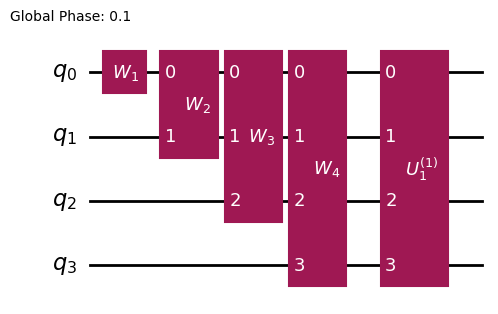

In [5]:
def V1(theta, n):
    # H1_circ for adv equation
    qc = QuantumCircuit(n, global_phase=theta, name='$V_1$')

    # apply wj
    for j in range(1, n+1):
        qc.append(Wj(j, theta, 0), range(j))

    # apply U_1^1
    qc.append(Wj(n, theta, 0, name='$U_1^{(1)}$', xgate=True), range(n))
    return qc

# example
test = V1(0.1, 4)
test.draw('mpl')

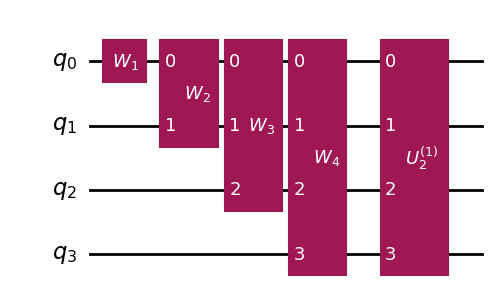

In [6]:
def V2(theta, n):
    # H2_circ for adv equation
    qc = QuantumCircuit(n, name='$V_2$')

    # apply wj
    for j in range(1, n+1):
        qc.append(Wj(j, theta, -np.pi/2), range(j))

    # apply U_2^1
    qc.append(Wj(n, theta, np.pi/2, name='$U_2^{(1)}$', xgate=True), range(n))
    return qc

# example
test = V2(0.1, 4)
test.draw('mpl')

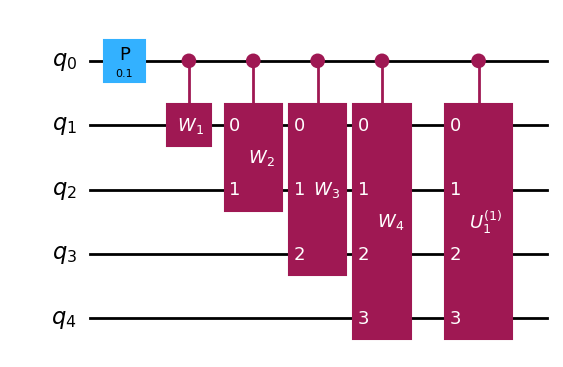

In [7]:
def cV1(theta, n):
    # cH1_circ for adv equation
    qc = QuantumCircuit(n+1, name='$cV_1$')

    qc.p(theta, 0)
    for j in range(1, n+1):
        cWj = Wj(j, theta, 0).to_gate().control()
        qc.append(cWj, range(j+1))
    
    cU1 = Wj(n, theta, 0, name='$U_1^{(1)}$', xgate=True).to_gate().control()
    qc.append(cU1, range(n+1))
    return qc

# example
test = cV1(0.1, 4)
test.draw('mpl')

# Schr&ouml;dingerisation

100%|██████████| 1/1 [00:00<00:00, 17.85it/s]


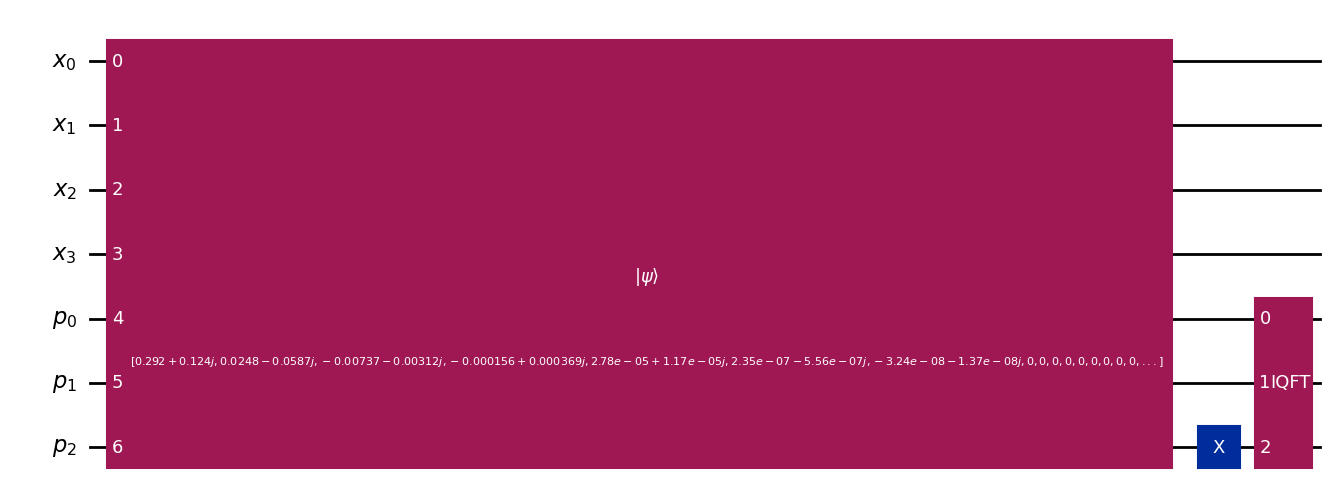

In [8]:
def schro(u0, iH1, cH1, H2=None, R=4, na=3, Nt=1, obs=None, E=None):
    # u0: initial condition
    # iH1_circ: circuit of H1
    # cH1_circ: controlled circuit of H1
    # H2_circ: circuit of H2
    # R: the area of p is -R*pi to R*pi
    # na: number of qubits for p, don't use the name "np" as it is a numpy module
    # Nt: number of time steps
    # obs: the observable to measure u
    # E: the expectation of the observable obtained by classical simulation

    # warped phase transformation
    dp = 2 * R * np.pi / 2**na
    p = np.arange(- R * np.pi, R * np.pi, step=dp)
    fp = np.exp(-np.abs(p))
    norm = np.linalg.norm(u0) * np.linalg.norm(fp)
    norm1 = np.linalg.norm(fp[2**(na-1):]) # norm of p>=0

    # construct the observable
    if obs is not None:
        values = np.zeros((2, Nt))
        # 'Estimator' is deprecated, use 'StatevectorEstimator' instead
        # the precision should be set as sqrt(var/shots)
        # var = E-E^2 is calculated by the classical simulation
        sampler = StatevectorSampler(default_shots=10000)
        estimator = StatevectorEstimator()
        E = E / norm**2
        var = E - E**2

        # Create the Pauli matrix I and Operators Zero and One
        zero_op = SparsePauliOp(['I', 'Z'], coeffs=[0.5, 0.5])
        one_op = SparsePauliOp(['I', 'Z'], coeffs=[0.5, -0.5])
        observable = one_op
        for i in range(na-1):
            observable = observable ^ zero_op
        observable = observable ^ obs
    else:
        values = None

    # construct quantum circuit
    nx = int(np.log2(u0.shape[0]))
    rx = QuantumRegister(nx, name='x')
    ra = QuantumRegister(na, name='p')
    qc = QuantumCircuit(rx, ra)

    # initialization
    qc.initialize(u0 / np.linalg.norm(u0), rx)
    qc.initialize(fp / np.linalg.norm(fp), ra)

    # QFT
    qft = QFT(na, inverse=False, do_swaps=True)
    iqft = QFT(na, inverse=True, do_swaps=True)
    qc.append(qft, ra)

    # after QFT, one gets \eta_0, \eta_1, ..., \eta_{Na/2-1}, -\eta_{Na/2}, ..., -\eta_1
    # rearrange eta to -\eta_{Na/2}, ..., -\eta_1, \eta_0, \eta_1, ..., \eta_{Na/2-1}
    qc.x(ra[-1])

    # Hamiltonian simulation for Nt steps
    for i in tqdm(range(Nt)):
        # circuit for one step
        for j in range(na):
            # repeat controlled H1 for 2**j times
            qc.append(cH1.repeat(2**j), [ra[j]] + rx[:])

        # repeat inverse H1 for 2**(na-1) times
        qc.append(iH1.repeat(2**(na-1)), rx[:])

        if H2 is not None:
            qc.append(H2, rx[:])

        if obs is not None:
            # measure the observable at each time step, projected to p=0
            circuit = qc.copy()
            circuit.x(ra[-1])
            circuit.append(iqft, ra)
            pub = (circuit, observable)
            job = estimator.run([pub], precision=np.sqrt(var[i])/100)
            values[0, i] = job.result()[0].data.evs * norm**2

            # the probabiliy of p>=0
            alpha = ClassicalRegister(1, name='alpha')
            circuit.add_register(alpha)
            circuit.measure(ra[-1], alpha)
            job = sampler.run([circuit])
            values[1, i] = job.result()[0].data.alpha.get_counts()['1'] / 10000 * norm**2 / norm1**2

        # reset the circuit, otherwise the circuit will be too long
        ut = Statevector(qc).data
        qc.clear()
        qc.initialize(ut / np.linalg.norm(ut), qc.qubits)

    # rearrange eta
    qc.x(ra[-1])
    
    # IQFT
    qc.append(iqft, ra)

    # project the solution to p=0 and rescale it
    u = np.real(Statevector(qc)).reshape(2**na, 2**nx)
    u = u[2**(na-1)] * norm
    return u, qc, values

def schro_calssical(u0, A, R=4, na=3, T=3):
    # u0: initial condition
    # A: the matrix A
    # R: the area of p is -R*pi to R*pi
    # na: number of qubits for p, don't use the name "np" as it is a numpy module
    # T: the final time

    # The hermitian part and the anti-hermitian part of A
    A1 = (A + A.T.conjugate()) / 2
    A2 = -1j * (A - A.T.conjugate()) / 2

    # The dimensions in :math:`x` and :math:`p`
    Nx = A1.shape[0]
    Na = 2**na

    # Warped phase transformation
    dp = 2 * R * np.pi / 2**na
    p = np.arange(- R * np.pi, R * np.pi, step=dp)
    fp = np.exp(-np.abs(p))
    up = u0 * fp[:,None]

    # The diagonal matrix of Fourier variable :math:`\eta`
    eta = np.arange(Na)
    eta[2**(na-1):] -= Na
    eta = eta / R
    diag_eta = sp.csc_matrix((eta, (range(Na), range(Na))), shape=[Na, Na])

    # QFT
    ueta = np.fft.fft(up, axis=0)
    ueta = ueta.flatten()

    # The total Hamiltonian
    H = sp.csc_matrix(sp.kron(diag_eta, A1) + sp.kron(sp.eye(Na), A2))

    # Run simulation
    ueta = sp.linalg.expm_multiply(1j * H * T, ueta)
    ueta = ueta.reshape(Na, Nx)
    up = np.fft.ifft(ueta, axis=0)
    up = np.real(up)

    # recover u from :math:`e^{p} * up`
    u = up[2**(na-1)] 

    return u

def matrix_exponential(u0, A, T=3):
    # u0: initial condition
    # A: the matrix A
    # T: the final time

    # Run simulation
    u = sp.linalg.expm_multiply(A * T, u0)

    return u

# example
u0 = np.zeros(16)
u0[0] = 1
iH1 = V0(0.1, 4)
cH1 = cV0(0.1, 4)
ut, qc, values = schro(u0, iH1=iH1, cH1=cH1)
qc.draw('mpl')

# Initial and Boundary conditions

- Heat equation, Dirichlet BC
$$
    \left\{ \begin{aligned}
        \partial_t u(t,x) &= a \partial_{xx} u(t,x), \\
        u(0,x) &= f(x),
    \end{aligned}\right. \quad x\in \Omega = [0,L].
$$

$$
    a = L/\pi^2, \quad f(x) = \sin(\pi x / L),
$$

$$
    u(t,x) = e^{-t/L} \sin(\pi x/L).
$$

- Advection equation, periodic BC
$$
    \left\{ \begin{aligned}
        \partial_t u(t,x) &= a \partial_{x} u(t,x), \\
        u(0,x) &= f(x),
    \end{aligned}\right. \quad x\in \Omega = [0,L].
$$

$$
    a = 1, \  f(x) = \left\{ 
    \begin{aligned}
        0, \quad x \in \left[kL, kL+L/2\right), \\
        1, \quad x \in \left[kL+L/2, kL\right),
    \end{aligned} \right.
$$

$$
    u(t,x) = f(x+at).
$$

In [9]:
def initial_adv(nx=4, L=2**4):
    # periodic boundary condition
    Nx = 2**nx
    dx = L / Nx
    x = np.arange(0, L, step=dx)
    u0 = 1 - ((x % L) < (L / 2))

    return x, u0, dx

def initial_heat(nx=4, L=2**4+1):
    # Dirichlet boundary condition
    Nx = 2**nx+1
    dx = L / Nx
    x = np.arange(dx, L, step=dx)
    u0 = np.sin(np.pi * x / L)

    return x, u0, dx

def exact_heat(x, L, T, a=1):
    num = a * np.pi**2 / L**2
    return np.sin(np.pi * x / L) * np.exp(-num*T)


def exact_adv(x, L, T, a=1):
    return 1 - (((x + a * T) % L) < (L / 2))

In [10]:
def coeff_heat(na=5, R=4, T=1, dt=0.005):
    # the coefficients of the heat equation
    nx = 4
    L = 2**nx + 1
    a = L / np.pi**2

    Nt = int(T / dt)
    t = np.arange(dt, T+dt, step=dt)
    x, u0, dx = initial_heat(nx=nx, L=L)

    # Define the evolving matrix using the central difference method
    A = -2 * np.eye(2**nx) + np.eye(2**nx, k=1) + np.eye(2**nx, k=-1)
    A = sp.csc_matrix(A) * a / dx**2

    # Define the quantum circuit
    gamma0 = a / dx**2
    theta = -2 * gamma0 * dt
    iH1 = V0(-theta / R, nx) # inverse H1
    cH1 = cV0(theta / R, nx) # controlled H1
    H2 = None

    return nx, L, a, x, t, dx, dt, u0, A, iH1, cH1, H2, R, na, Nt

def coeff_adv(na=5, R=4, T=1, dt=0.005):
    # the coefficients of the heat equation
    nx = 4
    L = 2**nx
    a = 1

    Nt = int(T / dt)
    t = np.arange(dt, T+dt, step=dt)
    x, u0, dx = initial_adv(nx=nx, L=L)

    # Define the evolving matrix using the upwind method
    A = - np.eye(2**nx) + np.eye(2**nx, k=1)
    A[-1,0] = 1
    A = sp.csc_matrix(A) * a / dx

    # Define the quantum circuit
    gamma1 = 1 / dx / 2
    theta = -2 * gamma1 * dt
    iH1 = V1(-abs(a) * theta / R, nx) # inverse H1
    cH1 = cV1(abs(a) * theta / R, nx) # controlled H1
    H2 = V2(a * theta, nx) # H2

    return nx, L, a, x, t, dx, dt, u0, A, iH1, cH1, H2, R, na, Nt

def run(name='heat', na=5, R=4, T=1, dt=0.005, measure=False):
    if name == 'heat':
        coeff = coeff_heat
        exact = exact_heat
    elif name == 'adv':
        coeff = coeff_adv
        exact = exact_adv
    else:
        raise ValueError('name should be either "heat" or "adv"')
    
    nx, L, a, x, t, dx, dt, u0, A, iH1, cH1, H2, R, na, Nt = coeff(na=na, R=R, T=T, dt=dt)
    if measure:
        # measure at each time step
        print('Running the classical simulation')
        obs = Pauli('I' * nx)
        values_classical, values_matrix, values_exact = np.zeros(Nt), np.zeros(Nt), np.zeros(Nt)

        for i in tqdm(range(1, Nt+1)):
            u_classical = schro_calssical(u0=u0, A=A, R=R, na=na, T=i*dt)
            u_matrix = matrix_exponential(u0=u0, A=A, T=i*dt)
            u_exact = exact(x=x, L=L, T=i*dt, a=a)

            values_classical[i-1] = np.linalg.norm(u_classical) ** 2
            values_matrix[i-1] = np.linalg.norm(u_matrix) ** 2
            values_exact[i-1] = np.linalg.norm(u_exact) ** 2
    else:
        # only check solutions at the final time
        obs, values_classical, values_matrix, values_exact = None, None, None, None
        u_classical = schro_calssical(u0=u0, A=A, R=R, na=na, T=Nt*dt)
        u_matrix = matrix_exponential(u0=u0, A=A, T=Nt*dt)
        u_exact = exact(x=x, L=L, T=Nt*dt, a=a)

    print('Running the quantum simulation')
    u, qc, values = schro(u0=u0, iH1=iH1, cH1=cH1, H2=H2, R=R, na=na, Nt=Nt, obs=obs, E=values_classical)

    if not os.path.exists(f'./{name}-{na}/'):
        os.makedirs(f'./{name}-{na}/')
    U = np.concatenate((u[None,:], u_classical[None,:], u_matrix[None,:], u_exact[None,:]), axis=0)
    V = None
    np.save(f'./{name}-{na}/{T}-{dt}-solution.npy', U)
    if measure:
        V = np.concatenate((values, values_classical[None,:], values_matrix[None,:], values_exact[None,:]), axis=0)
        np.save(f'./{name}-{na}/{T}-{dt}-norm.npy', V)

    return (x, t, dt, na, T), qc, U, V

In [11]:
def plot_solution(name, R=4, T=5, dt1=0.5, dt2=0.005, ylim=[0, 1.2]):
    fig, ax=plt.subplots(1,3, figsize=(24,7)) 
    for k in range(3):
        na = k*2 + 3 # 3, 5, 7
        x, qc, u, values = run(name=name, measure=False, na=na, R=R, T=T, dt=dt1)
        x1, qc1, u1, values1 = run(name=name, measure=False, na=na, R=R, T=T, dt=dt2)
        ax[k].plot(x[0], u[3], 'red', label='Exact')
        ax[k].plot(x[0], u[2], 'blue', linestyle='--', label='Matrix operator')
        ax[k].plot(x[0], u[1], color='black', linestyle='--', marker='s', label=f'Classical schro')
        ax[k].plot(x[0], u[0], 'd-', label=f'Proposed, dt={dt1}')
        ax[k].plot(x1[0], u1[0], 'd-', label=f'Proposed, dt={dt2}')

        ax[k].set_xlabel('x')
        ax[k].set_ylim(ylim)
        ax[k].set_title(f'T = {T}    $n_p$ = {na}')
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, bbox_to_anchor=(0.5, -0.05),loc=8,ncol=5, prop={'size':14})
    plt.savefig(f'./{name}-solution.pdf', dpi=600, format="pdf", bbox_inches="tight")


def plot_norm(name, na=7, R=4, T=5, dt=0.005):
    x, qc, u, values = run(name=name, measure=True, na=na, R=R, T=T, dt=dt)
    plt.figure()
    plt.plot(x[1], values[4], 'red')
    plt.plot(x[1], values[3], 'blue', linestyle='--')
    plt.plot(x[1], values[2], 'black')
    plt.plot(x[1], values[1], 'mediumseagreen', linestyle='dotted')
    plt.plot(x[1], values[0], 'orange', linestyle='dotted')
    plt.legend(['Exact', 'Matrix operator', f'Classical Schro, $n_p$={x[3]}', f'Proposed, $n_p$={x[3]}, $p=0$', f'Proposed, $n_p$={x[3]}, $p\geq0$'])
    plt.xlabel('T')
    plt.title(f'{name}, $\|u\|^2$')
    plt.savefig(f'./{name}-norm.pdf', dpi=600, format="pdf", bbox_inches="tight")

<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\|'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\|'
C:\Users\bearx666\AppData\Local\Temp\ipykernel_12992\176473591.py:29: SyntaxWarning: invalid escape sequence '\g'
  plt.legend(['Exact', 'Matrix operator', f'Classical Schro, $n_p$={x[3]}', f'Proposed, $n_p$={x[3]}, $p=0$', f'Proposed, $n_p$={x[3]}, $p\geq0$'])
C:\Users\bearx666\AppData\Local\Temp\ipykernel_12992\176473591.py:31: SyntaxWarning: invalid escape sequence '\|'
  plt.title(f'{name}, $\|u\|^2$')


# Run

## Heat equation

Running the quantum simulation


100%|██████████| 10/10 [00:00<00:00, 14.04it/s]


Running the quantum simulation


100%|██████████| 1000/1000 [01:19<00:00, 12.55it/s]


Running the quantum simulation


100%|██████████| 10/10 [00:03<00:00,  3.06it/s]


Running the quantum simulation


100%|██████████| 1000/1000 [05:50<00:00,  2.85it/s]


Running the quantum simulation


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Running the quantum simulation


100%|██████████| 1000/1000 [30:23<00:00,  1.82s/it]


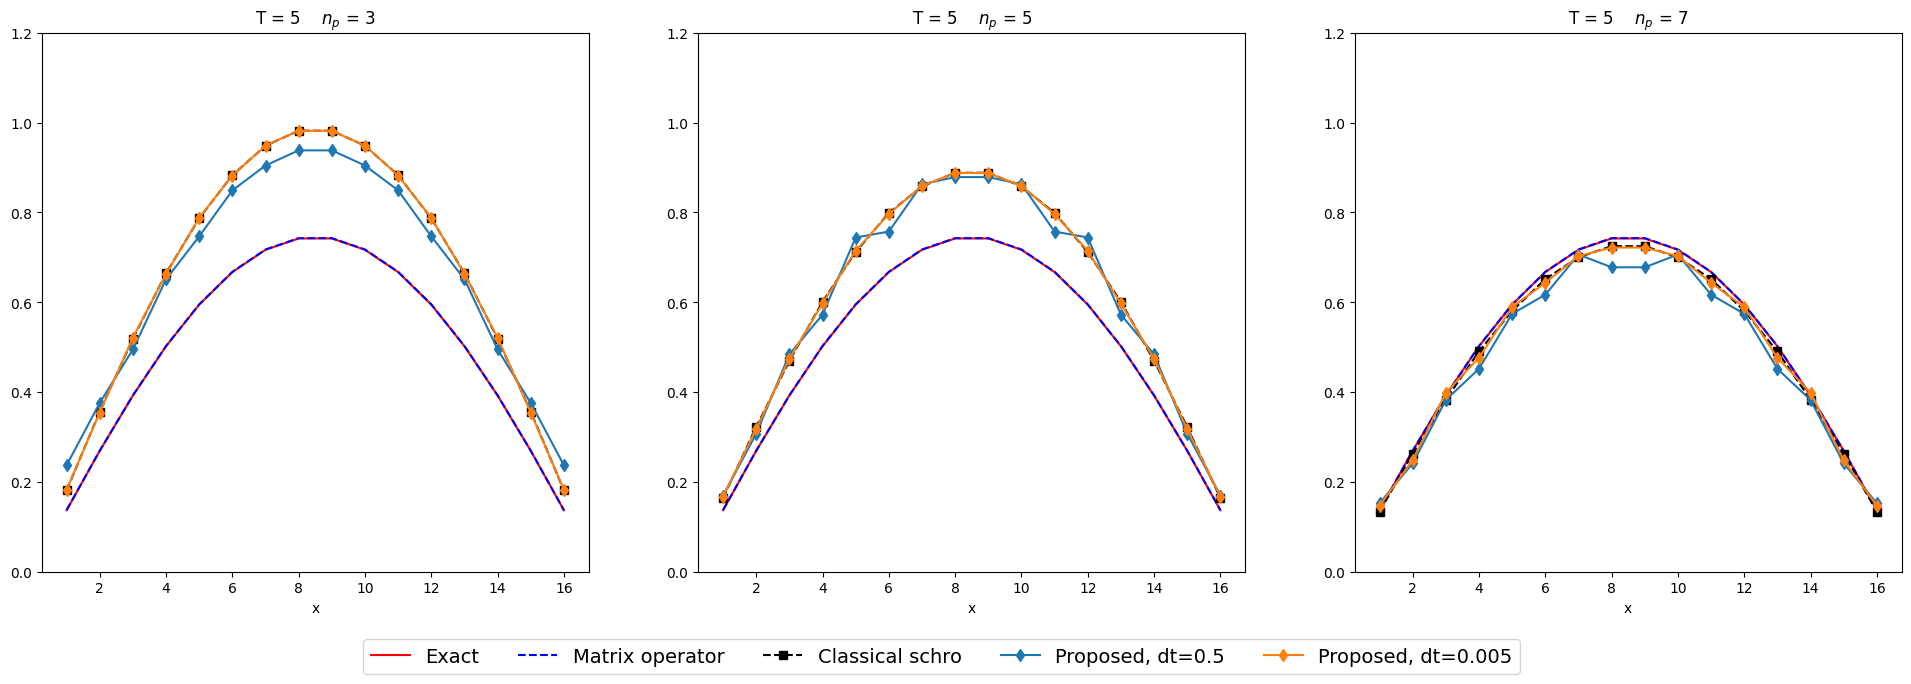

In [12]:
# plot the solution
plot_solution('heat', T=5, ylim=[0, 1.2])

Running the quantum simulation


100%|██████████| 6/6 [00:00<00:00,  6.82it/s]


Running the quantum simulation


100%|██████████| 600/600 [01:09<00:00,  8.67it/s]


Running the quantum simulation


100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Running the quantum simulation


100%|██████████| 600/600 [04:56<00:00,  2.02it/s]


Running the quantum simulation


100%|██████████| 6/6 [00:14<00:00,  2.44s/it]


Running the quantum simulation


100%|██████████| 600/600 [25:25<00:00,  2.54s/it]


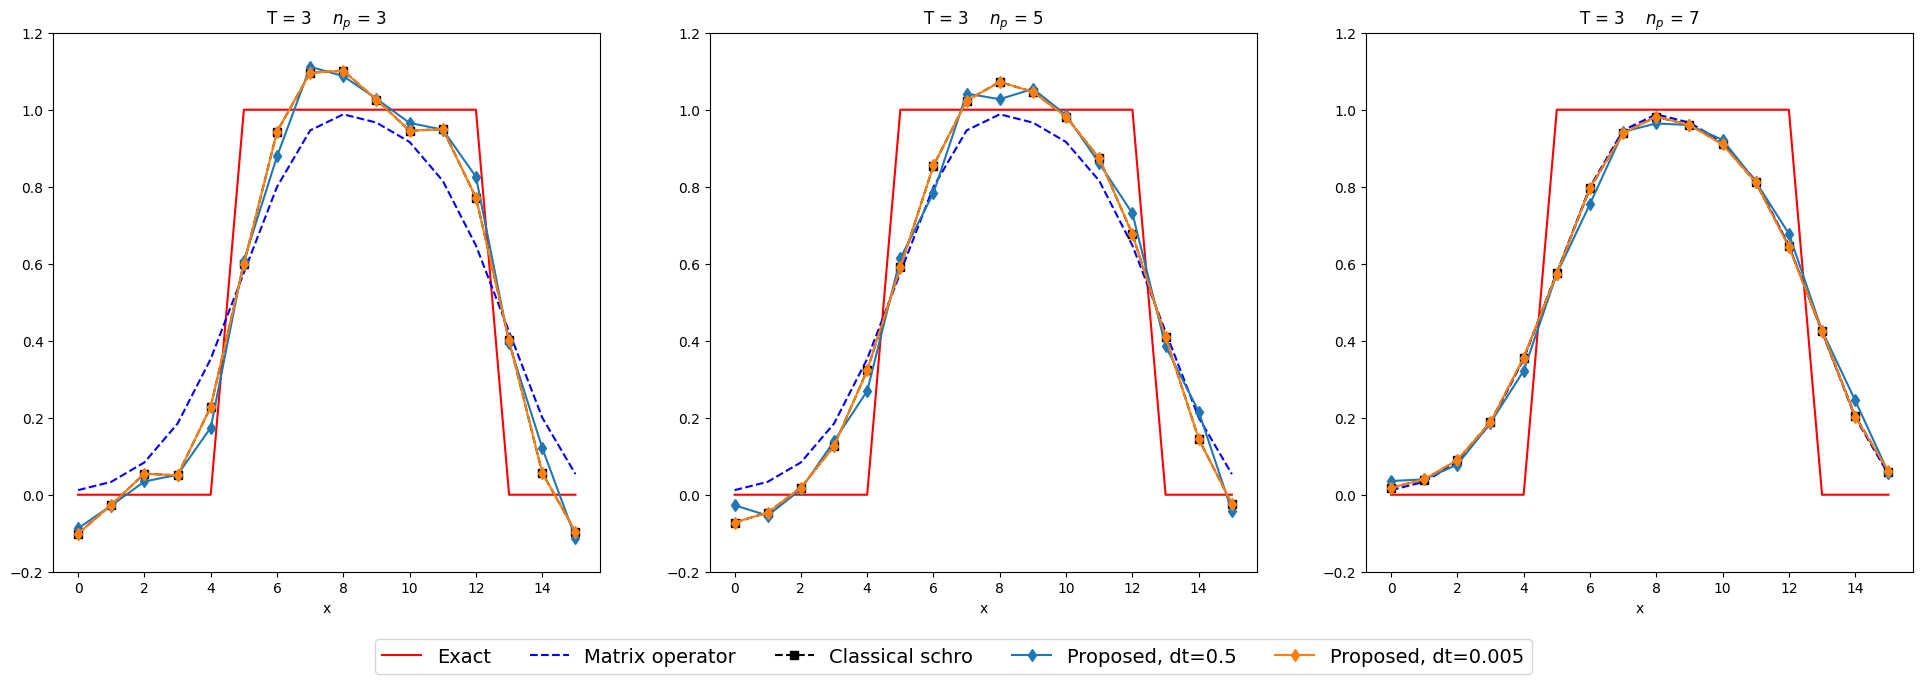

In [13]:
plot_solution('adv', T=3, ylim=[-0.2, 1.2])

Running the classical simulation


100%|██████████| 1000/1000 [00:32<00:00, 30.34it/s]


Running the quantum simulation


100%|██████████| 1000/1000 [1:41:41<00:00,  6.10s/it]


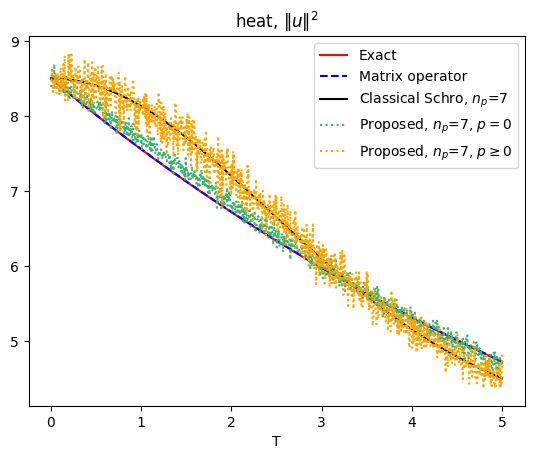

In [14]:
plot_norm('heat', na=7, T=5)

Running the classical simulation


100%|██████████| 1000/1000 [00:20<00:00, 49.88it/s]


Running the quantum simulation


100%|██████████| 1000/1000 [2:30:15<00:00,  9.02s/it] 


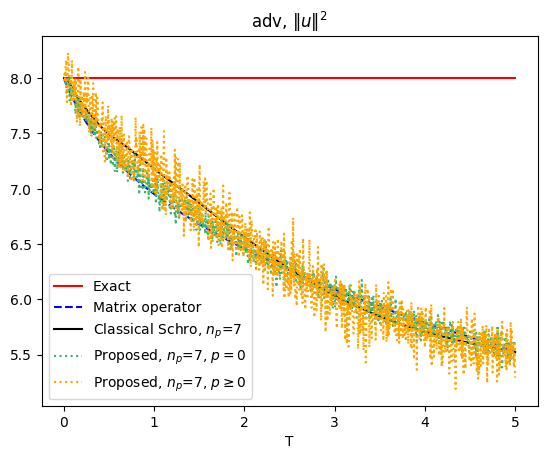

In [15]:
plot_norm('adv', na=7, T=5)